In [2]:
#######################
#      Imports        # 
#                     #
#######################


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt 
import torch 
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
datadir = 'D:/AI&ML/Udacity/deep-learning-v2-pytorch/intro-to-pytorch' #Listing data directory 

train_on_gpu = torch.cuda.is_available() #Checking for GPU availbility to allow for faster and parallel training of the CNN

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(65),
    transforms.CenterCrop(64),
    ]) #Data processing, defining transforms to reize all images to 64x64 

batch_size = 10 #Defining batchsize per iteration 

validation_data = 0.2 #Assigning 20% of the training data for the validation training of the net 

train_data = datasets.ImageFolder(datadir + '/train', transform=transform) #defining the training DIR
test_data = datasets.ImageFolder(datadir + '/test', transform=transform) #defining the testing DIR 

#Creating Validation DataSet 

num_train = len(train_data) 
indices = list(range(num_train)) #listing the indices of all the training images
np.random.shuffle(indices) #shuffling the indices in the training data 
split = int(np.floor(validation_data*num_train)) #grabbing 20% of them 
train_idx, valid_idx = indices[split:], indices[:split] #assigning the validation images as the last 20% of the images in array 

train_sampler = SubsetRandomSampler(train_idx) #defining that these are subsets of each other and defining samplers
valid_sampler = SubsetRandomSampler(valid_idx)

#defining trainloaders 

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler) 
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [4]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0))) #creating a function that transposes the RGB image defining dimesions and colour changes

tensor(0)


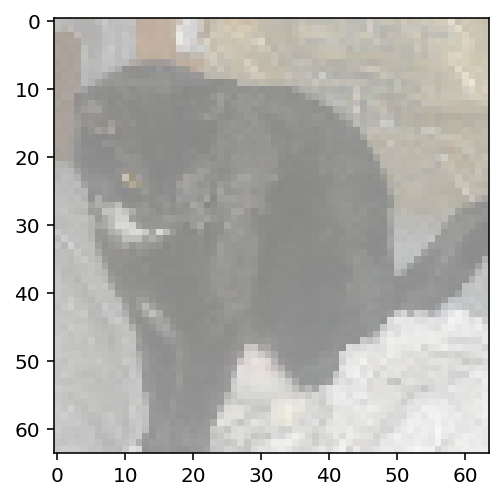

In [5]:
#datavisualization

dataiter = iter(train_loader)
images, labels = dataiter.next() 

imshow(images[8]) 

print(labels[8])

In [6]:
###Defining Model Architecture### 

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(3,16,3, padding=1) #64x64x3 --> Image is 64x64 with 3 colour channels so the dim is 64x646x3
        # (starting with 3 channles because 3 color channels (RGB), next layer has 16)
        
        
        self.conv2 = nn.Conv2d(16,32,3, padding=1) #32x32x16  64/2 (maxpool with size2) = 32 but this time 16 colour channels 
        self.conv3 = nn.Conv2d(32,64,3, padding=1) #16x16x32
        self.conv4 = nn.Conv2d(64,128,3, padding=1) #8*8*64
        self.conv5 = nn.Conv2d(128,256,3, padding=1) #4*4*128
        
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(1024, 512) # output from the CNN layer would be in the form of (4x4x128)/2 = 1024 hence 1024 inputlayers  
        self.fc2 = nn.Linear(512, 264)
        self.fc3 = nn.Linear(264, 10)
        self.fc4 = nn.Linear(10,2)
        self.dropout = nn.Dropout(p=0.2) # each layer has a 20% chance of dropout to allow for better model training
  
    #Defining Feed Forward. Maxpooled(CNN) --> Fully Connected Linear Layer --> Log_Softmax Output For Dim =1 (probabilities)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = self.maxpool(F.relu(self.conv5(x)))
        x = x.view(x.shape[0],-1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc4(x),dim=1) 
        return x 

model = Network() #assigning the "model" variable to this network
print(model)

if train_on_gpu:
    model.cuda() #if gpu is available, conver the model data types and model movement to CUDA style outputs 

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=264, bias=True)
  (fc3): Linear(in_features=264, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [7]:
criterion = nn.NLLLoss() #defining loss function 
optimizer = optim.Adam(model.parameters(), lr=0.001) #defining method of gradient descent on model parameters(w,b) and learning rate 

In [8]:
#Training the giant 

epochs = 45 #defining the number of epochs to train for 
valid_loss_min = np.Inf #setting intial validation loss to infinity so the first time around val loss < infinity 
valid = [] 
train = []
ep = []
x = 0
for e in range(epochs):
    training_loss = 0
    validation_loss = 0 
    for images, labels in train_loader: #iterate through all the images in the trainloader utilising listed batch size
        model.train() #setting the model to train mode, tells model to train with dropout 
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda() #if gpu is available, change image and label datatype to CUDA style 
        optimizer.zero_grad() #remove previous batch loss scores from the optimizer every iteration 
        output = model(images) #run the image through the model as input
        loss = criterion(output,labels) #calculate comparative loss 
        loss.backward() #perform backpropogation distributing error ratings to invidual nodes and clusters 
        optimizer.step() #take the best gradient step
        
        training_loss += loss.item()*images.size(0) #update training loss variable for this epoch 
        
    else:
        for images, labels in valid_loader:
            model.eval() #set model on evaluation mode 
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
            output = model(images)
            loss = criterion(output,labels)
            validation_loss += loss.item()*images.size(0) #update validation loss 
        
    
    total_training_loss = training_loss / len(train_loader.sampler) #find the average training_loss for a given epoch 
    total_valid_loss = validation_loss/ len(valid_loader.sampler) #find the average validation loss for a given epoch 
    x += 1
    print(f'Epoch {e+1}/{epochs}...Validation Loss: {total_valid_loss}...Training Loss: {total_training_loss}')
    
    valid.append(total_valid_loss)
    train.append(total_training_loss)
    ep.append(x)
    
    if total_valid_loss <= valid_loss_min:
        print('Saving This Model... Validation Loss Decreased') 
        torch.save(model.state_dict(), 'goodboy.pt') #if the validation loss decreased from the previous epoch, save this version
        valid_loss_min = total_valid_loss #update validation loss variable. 


C:\Users\thaku\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/45...Validation Loss: 0.6932440954446792...Training Loss: 0.6910864084362983
Saving This Model... Validation Loss Decreased
Epoch 2/45...Validation Loss: 0.6161891971826553...Training Loss: 0.644594575688243
Saving This Model... Validation Loss Decreased
Epoch 3/45...Validation Loss: 0.5236718425899745...Training Loss: 0.5557595434710383
Saving This Model... Validation Loss Decreased
Epoch 4/45...Validation Loss: 0.47268413291871547...Training Loss: 0.4891777652055025
Saving This Model... Validation Loss Decreased
Epoch 5/45...Validation Loss: 0.4403644217252731...Training Loss: 0.44589889848232267
Saving This Model... Validation Loss Decreased
Epoch 6/45...Validation Loss: 0.42652329441905024...Training Loss: 0.4123465134780854
Saving This Model... Validation Loss Decreased
Epoch 7/45...Validation Loss: 0.41430361653119324...Training Loss: 0.37594754572026434
Saving This Model... Validation Loss Decreased
Epoch 8/45...Validation Loss: 0.39957218535244465...Training Loss: 0.353

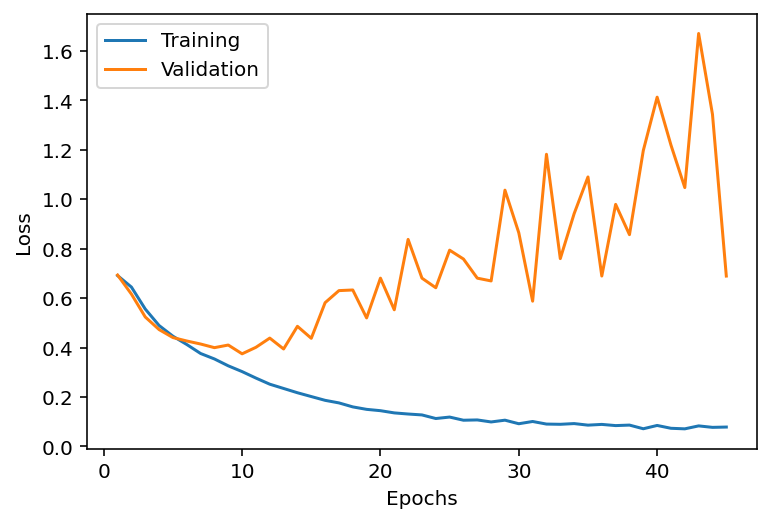

In [9]:
model.load_state_dict(torch.load('goodboy.pt')) #load model with best validation 

#plotting validation and training data per epoch to check for overfitting 

plt.plot(ep, train, label='Training')
plt.plot(ep, valid, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
#Testing the giant 

testing_loss = 0
test_acc = 0
for images, labels in test_loader:
    model.eval()
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    loss = criterion(output, labels)
    testing_loss += loss.item()
    
    ps = torch.exp(output) #Translate the scores from the model to probabilities for the image being a cat or dog
    top_p, top_class = ps.topk(1, dim=1) #pick the highest probability for a given image and store it in top_class 
    equals = top_class == labels.view(*top_class.shape)  # if top_class probability and label agree value =1 else 0 
    test_acc += torch.mean(equals.type(torch.FloatTensor)) #update the test accuracy variable 
    
print(f'Testing Accuracy = {test_acc / len(test_loader)}') #print testing accuracy for the model 
print(f'Testing Loss = {testing_loss / len(test_loader)}') #print testing loss for the model 

Testing Accuracy = 0.47951972484588623
Testing Loss = 1.3717604376196861


I see a cat!


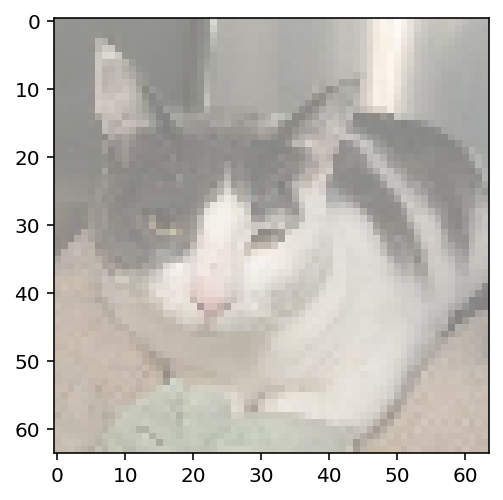

In [11]:
#Make actual predictions

model.eval()
dataiter = iter(test_loader)
images, labels = dataiter.next()

x = 9

img = images[x]
imshow(img)
if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()

output = model(images)
ps = torch.exp(output)

top_p, top_class = ps.topk(1, dim=1)

top_class = top_class.cpu()
top_class = top_class.numpy()

prediction = top_class[x]

if prediction == [0]:
    print('I see a cat!')
else:
    print('I see a dog!')
